# COMP5623 Coursework on Image Caption Generation

Starter code.



## Text preparation 

We need to build a vocabulary.

In [1]:
# Mounted Drive if using Colab; otherwise, your local path
root = "data/Flickr8k/" # <--- replace this with your root data directory
caption_dir = root + "captions/"                       # <--- replace these too
image_dir = root + "images/"                           # <---

token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [2]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [3]:
lines = read_lines(caption_dir + token_file)

In [4]:
lines[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [5]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [6]:
import re
import string
from tqdm import tqdm
from nltk import FreqDist

captions = {}
for line in lines:
    img_num, caption = line.split('\t')
    img, num = img_num.split('#')
    # remove the empty caption 2258277193_586949ec62
    if '2258277193_586949ec62' not in img:
        if img not in captions:
            captions[img] = [caption]
        else:
            captions[img].append(caption)
            
print(captions['1000268201_693b08cb0e.jpg'])

words = []

for key, value in tqdm(captions.items()):
    for cap in value:
        cap = re.sub('[%s]' % re.escape(string.punctuation),'', cap)
        cap = cap.strip()
        cap = cap.lower()
        words.extend(cap.split())

print(len(words))
freq_dist = FreqDist(words)
print(freq_dist.most_common(5))

 44%|████▍     | 3579/8091 [00:00<00:00, 35779.12it/s]

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


100%|██████████| 8091/8091 [00:00<00:00, 33020.33it/s]


436505
[('a', 62986), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345)]


Build the vocabulary.

In [7]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

for word in words:
    if freq_dist[word] > 3:
        vocab.add_word(word)

print(len(vocab))

3440


Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [8]:
image_ids, cleaned_captions = list(), list()

for key, value in tqdm(captions.items()):
    cleaned_caption = []
    for cap in value:
        cap = re.sub('[%s]' % re.escape(string.punctuation),'', cap)
        cap = cap.strip()
        cap = cap.lower()
        image_ids.append(key[:-4])
        cleaned_captions.append(cap)
    
print(image_ids[:5])
print(cleaned_captions[:5])

100%|██████████| 8091/8091 [00:00<00:00, 27803.27it/s]

['1000268201_693b08cb0e', '1000268201_693b08cb0e', '1000268201_693b08cb0e', '1000268201_693b08cb0e', '1000268201_693b08cb0e']
['a child in a pink dress is climbing up a set of stairs in an entry way', 'a girl going into a wooden building', 'a little girl climbing into a wooden playhouse', 'a little girl climbing the stairs to her playhouse', 'a little girl in a pink dress going into a wooden cabin']


The dataframe for the image paths and captions.

In [9]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [10]:
data_df.head()

,image_id,path,caption
0,1000268201_693b08cb0e,data/Flickr8k/images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,data/Flickr8k/images/1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201_693b08cb0e,data/Flickr8k/images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,data/Flickr8k/images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,data/Flickr8k/images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


This is the Flickr8k class for the dataset.

In [11]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [12]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [13]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [14]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [23]:
import torch

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=caption_collate_fn)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=True, collate_fn=caption_collate_fn)

## Encoder and decoder models

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        with torch.no_grad():
            features = self.resnet(images).squeeze()
        features = self.linear(features)
        features = self.bn(features)
        
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, rnn_lstm = 'RNN',max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm / self.rnn
        if rnn_lstm == 'RNN':
            self.layer = nn.RNN(embed_size, hidden_size, num_layers = 1, bidirectional=False)
        else:
            self.layer =  nn.LSTM(embed_size, hidden_size, num_layers = 1, bidirectional=False)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.layer(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.layer(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [17]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set training parameters.

In [18]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 100

Initialize the models and set the learning parameters.

In [19]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)

## Training the model

The loop to train the model. Feel free to put this in a function if you prefer.

In [20]:
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

# Train the RNN models
model_path = 'checkpoints/'

losses = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    
    epoch_bleu = list()
    
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        losses.append(loss.item())

        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            sample_ids = decoder.sample(features)
        
        batch_bleu = 0.0
        for b in range(captions.shape[0]):
            reference = captions[b].detach().cpu().tolist()
            reference = [vocab.idx2word[i] for i in reference if i not in list(range(0,4))]

            hypothese = sample_ids[b].detach().cpu().tolist()
            hypothese = [vocab.idx2word[hypo] for hypo in hypothese if hypo not in list(range(0,4))]
            
            batch_bleu += sentence_bleu(reference, hypothese)
            
        batch_bleu /= captions.shape[0]
        epoch_bleu.append(batch_bleu)

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i, total_step, loss.item())) 

        # If you want to save the model checkpoints - recommended once you have everything working
        # Make sure to save RNN and LSTM versions separately
        if (i+1) % save_step == 0:
            torch.save(decoder.state_dict(), model_path + 'rnn-decoder-{}-{}.ckpt'.format(epoch+1, i+1))
            torch.save(encoder.state_dict(), model_path + 'rnn-encoder-{}-{}.ckpt'.format(epoch+1, i+1))


/root/workspace/anaconda3/envs/detectron/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/root/workspace/anaconda3/envs/detectron/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/root/workspace/anaconda3/envs/detectron/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it c

Epoch [1/5], Step [0/301], Loss: 8.1784
Epoch [1/5], Step [10/301], Loss: 5.3081
Epoch [1/5], Step [20/301], Loss: 5.0831
Epoch [1/5], Step [30/301], Loss: 4.7353
Epoch [1/5], Step [40/301], Loss: 4.4021
Epoch [1/5], Step [50/301], Loss: 4.2378
Epoch [1/5], Step [60/301], Loss: 3.9661
Epoch [1/5], Step [70/301], Loss: 3.9022
Epoch [1/5], Step [80/301], Loss: 3.6237
Epoch [1/5], Step [90/301], Loss: 3.8068
Epoch [1/5], Step [100/301], Loss: 3.7264
Epoch [1/5], Step [110/301], Loss: 3.5488
Epoch [1/5], Step [120/301], Loss: 3.5778
Epoch [1/5], Step [130/301], Loss: 3.4093
Epoch [1/5], Step [140/301], Loss: 3.4333
Epoch [1/5], Step [150/301], Loss: 3.3320
Epoch [1/5], Step [160/301], Loss: 3.1715
Epoch [1/5], Step [170/301], Loss: 3.1810
Epoch [1/5], Step [180/301], Loss: 3.3155
Epoch [1/5], Step [190/301], Loss: 3.1780
Epoch [1/5], Step [200/301], Loss: 3.2137
Epoch [1/5], Step [210/301], Loss: 3.3121
Epoch [1/5], Step [220/301], Loss: 3.1617
Epoch [1/5], Step [230/301], Loss: 3.1392
Epo

### Plot the loss curve of the RNN model

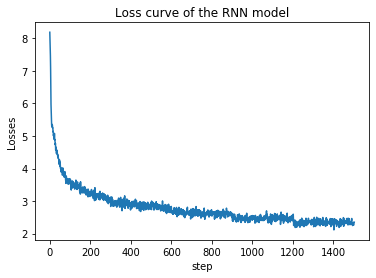

In [23]:
import matplotlib.pyplot as plt

x = list(range(len(losses)))
y = losses

plt.figure()
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('Losses')
plt.title("Loss curve of the RNN model")
plt.show()

In [ ]:
# Visualization and BLEU score calculation of RNN Model
import matplotlib.pyplot as plt

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


encoder.load_state_dict(torch.load('checkpoints/rnn-encoder-1-300.ckpt'))
decoder.load_state_dict(torch.load('checkpoints/rnn-decoder-1-300.ckpt'))

encoder.eval()
decoder.eval()


sample_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=caption_collate_fn)
image,caption,length = next(iter(sample_loader))
image, caption = image.to(device), caption.to(device)

image = unorm(image)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image[0, :,:,:].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(image[1, :, :, :].permute(1,2,0).cpu().numpy())

feats = encoder(image)
sample_ids = decoder.sample(feats)
hypothese = sample_ids[0].cpu().tolist()
hypothese = [vocab.idx2word[hypo] for hypo in hypothese if hypo not in list(range(0,4))]
print(hypothese)

reference = caption.cpu().tolist()
refs = []
for i in range(2):
    ref = [vocab.idx2word[i] for i in reference[i] if i not in list(range(0,4))]
    refs.append(ref)
print(refs)

bleu = sentence_bleu(refs, hypothese)
print(bleu)
plt.title("{} (BLEU Scores:{})".format(" ".join(hypothese), bleu))
# plt.savefig("tmp_epoch_{}_sample.png".format(epoch))
plt.show()
plt.close()

### Train the LSTM Model

In [30]:
import numpy as np
model_path = 'checkpoints/'

# Build the models
lencoder = EncoderCNN(embed_size).to(device)
ldecoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers, rnn_lstm = 'LSTM').to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
lparams = list(
    ldecoder.parameters()) + list(lencoder.linear.parameters()) + list(lencoder.bn.parameters()
)

loptimizer = torch.optim.SGD(lparams, lr=learning_rate, momentum=0.9)


# Train the LSTM models
total_step = len(train_loader)

losses = []

for epoch in range(num_epochs):
    
    epoch_bleu = list()
    
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = lencoder(images)
        outputs = ldecoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        loptimizer.step()
        
        with torch.no_grad():
            sample_ids = decoder.sample(features)
        
        batch_bleu = 0.0
        for b in range(captions.shape[0]):
            reference = captions[b].detach().cpu().tolist()
            reference = [vocab.idx2word[i] for i in reference if i not in list(range(3436,3441))]

            hypothese = sample_ids[b].detach().cpu().tolist()
            hypothese = [vocab.idx2word[hypo] for hypo in hypothese if hypo not in list(range(3436,3441))]
            
            batch_bleu += sentence_bleu(reference, hypothese)
            
        batch_bleu /= captions.shape[0]
        epoch_bleu.append(batch_bleu)

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i, total_step, loss.item())) 

        # If you want to save the model checkpoints - recommended once you have everything working
        # Make sure to save RNN and LSTM versions separately
        if (i+1) % save_step == 0:
            torch.save(decoder.state_dict(), model_path + 'lstm-decoder-{}-{}.ckpt'.format(epoch+1, i+1))
            torch.save(encoder.state_dict(), model_path + 'lstm-encoder-{}-{}.ckpt'.format(epoch+1, i+1))
    
        # Visualization
    sample_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=caption_collate_fn)
    image,caption,length = next(iter(sample_loader))
    image, caption = image.to(device), caption.to(device)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(image[0].squeeze().permute(1,2,0).cpu().numpy(),cv2.COLOR_BGR2RGB))
    feats = encoder(image)
    sample_ids = decoder.sample(feats)
    hypothese = sample_ids[0].cpu().tolist()
    hypothese = [vocab.idx2word[hypo] for hypo in hypothese if hypo not in list(range(0,4))]
    print(hypothese)

    reference = caption[0].cpu().tolist()
    reference = [vocab.idx2word[i] for i in reference if i not in list(range(0,4))]
    plt.title("{} (BLEU Scores:{})".format(" ".join(hypothese), sentence_bleu(reference, hypothese)))
    plt.savefig("lstm_epoch_{}_sample1.png".format(epoch))
    
    hypothese = sample_ids[1].cpu().tolist()
    hypothese = [vocab.idx2word[hypo] for hypo in hypothese if hypo not in list(range(0,4))]
    
    print(hypothese)
    plt.title("{} (BLEU Scores:{})".format(" ".join(hypothese), sentence_bleu(reference, hypothese)))
    plt.savefig("lstm_epoch_{}_sample2.png".format(epoch))

    plt.close()
          
    # calculate the bleu score for each epoch
    print("Epoch {}/{} BLEU Scores : {}".format(epoch + 1, num_epochs, np.mean(epoch_bleu)))

Epoch [1/5], Step [0/301], Loss: 8.1483
Epoch [1/5], Step [10/301], Loss: 8.1364
Epoch [1/5], Step [20/301], Loss: 8.0713
Epoch [1/5], Step [30/301], Loss: 7.9434
Epoch [1/5], Step [40/301], Loss: 7.7200
Epoch [1/5], Step [50/301], Loss: 7.4073
Epoch [1/5], Step [60/301], Loss: 7.1024
Epoch [1/5], Step [70/301], Loss: 7.2787
Epoch [1/5], Step [80/301], Loss: 6.9981
Epoch [1/5], Step [90/301], Loss: 6.3733
Epoch [1/5], Step [100/301], Loss: 6.5201
Epoch [1/5], Step [110/301], Loss: 6.7206
Epoch [1/5], Step [120/301], Loss: 6.8510
Epoch [1/5], Step [130/301], Loss: 6.4819
Epoch [1/5], Step [140/301], Loss: 6.0171
Epoch [1/5], Step [150/301], Loss: 6.8067
Epoch [1/5], Step [160/301], Loss: 7.0351
Epoch [1/5], Step [170/301], Loss: 6.9849
Epoch [1/5], Step [180/301], Loss: 6.6157
Epoch [1/5], Step [190/301], Loss: 6.7282
Epoch [1/5], Step [200/301], Loss: 7.0570
Epoch [1/5], Step [210/301], Loss: 7.1877
Epoch [1/5], Step [220/301], Loss: 7.2696
Epoch [1/5], Step [230/301], Loss: 6.3012
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/5], Step [300/301], Loss: 5.2798
['a', 'man', 'and', 'a', 'black', 'and', 'white', 'dog', 'is', 'running', 'in', 'the', 'grass']
['a', 'man', 'in', 'a', 'blue', 'and', 'white', 'dog', 'in', 'the', 'field', 'of', 'water']
Epoch 1/5 BLEU Scores : 2.3913818324483562e-232
Epoch [2/5], Step [0/301], Loss: 5.3755
Epoch [2/5], Step [10/301], Loss: 5.3908
Epoch [2/5], Step [20/301], Loss: 5.6598
Epoch [2/5], Step [30/301], Loss: 5.8341
Epoch [2/5], Step [40/301], Loss: 5.9044
Epoch [2/5], Step [50/301], Loss: 5.5820
Epoch [2/5], Step [60/301], Loss: 5.3674
Epoch [2/5], Step [70/301], Loss: 5.2608
Epoch [2/5], Step [80/301], Loss: 5.1116
Epoch [2/5], Step [90/301], Loss: 5.0388
Epoch [2/5], Step [100/301], Loss: 5.4441
Epoch [2/5], Step [110/301], Loss: 5.8275
Epoch [2/5], Step [120/301], Loss: 5.8536
Epoch [2/5], Step [130/301], Loss: 5.8156
Epoch [2/5], Step [140/301], Loss: 5.4512
Epoch [2/5], Step [150/301], Loss: 4.9960
Epoch [2/5], Step [160/301], Loss: 4.9208
Epoch [2/5], Step [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/5], Step [300/301], Loss: 4.6141
['a', 'man', 'and', 'woman', 'are', 'playing', 'in', 'a', 'field']
['a', 'man', 'and', 'a', 'little', 'girl', 'in', 'a', 'field']
Epoch 2/5 BLEU Scores : 4.056066519014401e-232
Epoch [3/5], Step [0/301], Loss: 5.0848
Epoch [3/5], Step [10/301], Loss: 5.1228
Epoch [3/5], Step [20/301], Loss: 5.1978
Epoch [3/5], Step [30/301], Loss: 5.1949
Epoch [3/5], Step [40/301], Loss: 5.2129
Epoch [3/5], Step [50/301], Loss: 5.1874
Epoch [3/5], Step [60/301], Loss: 5.0789
Epoch [3/5], Step [70/301], Loss: 5.0002
Epoch [3/5], Step [80/301], Loss: 5.0797
Epoch [3/5], Step [90/301], Loss: 4.9561
Epoch [3/5], Step [100/301], Loss: 5.0251
Epoch [3/5], Step [110/301], Loss: 4.9006
Epoch [3/5], Step [120/301], Loss: 4.9212
Epoch [3/5], Step [130/301], Loss: 4.8087
Epoch [3/5], Step [140/301], Loss: 4.7855
Epoch [3/5], Step [150/301], Loss: 4.8847
Epoch [3/5], Step [160/301], Loss: 5.0179
Epoch [3/5], Step [170/301], Loss: 5.0625
Epoch [3/5], Step [180/301], Loss: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/5], Step [300/301], Loss: 5.0600
['a', 'man', 'and', 'woman', 'wear']
['a', 'man', 'in', 'a', 'black', 'and', 'a']
Epoch 3/5 BLEU Scores : 5.8873980917098435e-232
Epoch [4/5], Step [0/301], Loss: 4.8493
Epoch [4/5], Step [10/301], Loss: 4.9487
Epoch [4/5], Step [20/301], Loss: 4.8770
Epoch [4/5], Step [30/301], Loss: 4.9694
Epoch [4/5], Step [40/301], Loss: 5.1988
Epoch [4/5], Step [50/301], Loss: 4.9646
Epoch [4/5], Step [60/301], Loss: 4.9583
Epoch [4/5], Step [70/301], Loss: 5.3976
Epoch [4/5], Step [80/301], Loss: 5.1498
Epoch [4/5], Step [90/301], Loss: 4.9940
Epoch [4/5], Step [100/301], Loss: 4.9872
Epoch [4/5], Step [110/301], Loss: 4.9096
Epoch [4/5], Step [120/301], Loss: 4.8540
Epoch [4/5], Step [130/301], Loss: 5.1530
Epoch [4/5], Step [140/301], Loss: 4.7730
Epoch [4/5], Step [150/301], Loss: 5.2047
Epoch [4/5], Step [160/301], Loss: 4.9937
Epoch [4/5], Step [170/301], Loss: 5.1160
Epoch [4/5], Step [180/301], Loss: 4.9566
Epoch [4/5], Step [190/301], Loss: 5.1686

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/5], Step [300/301], Loss: 4.8779
['a', 'man', 'and', 'woman', 'are', 'walking', 'on', 'a', 'field']
['a', 'man', 'and', 'a', 'little', 'girl', 'in', 'a', 'field']
Epoch 4/5 BLEU Scores : 6.127968474175544e-232
Epoch [5/5], Step [0/301], Loss: 4.9094
Epoch [5/5], Step [10/301], Loss: 4.8920
Epoch [5/5], Step [20/301], Loss: 4.8657
Epoch [5/5], Step [30/301], Loss: 5.0706
Epoch [5/5], Step [40/301], Loss: 4.9477
Epoch [5/5], Step [50/301], Loss: 4.9898
Epoch [5/5], Step [60/301], Loss: 5.0450
Epoch [5/5], Step [70/301], Loss: 5.0714
Epoch [5/5], Step [80/301], Loss: 5.2586
Epoch [5/5], Step [90/301], Loss: 5.1885
Epoch [5/5], Step [100/301], Loss: 5.1808
Epoch [5/5], Step [110/301], Loss: 5.2004
Epoch [5/5], Step [120/301], Loss: 5.2174
Epoch [5/5], Step [130/301], Loss: 5.0279
Epoch [5/5], Step [140/301], Loss: 5.2383
Epoch [5/5], Step [150/301], Loss: 4.9318
Epoch [5/5], Step [160/301], Loss: 5.0316
Epoch [5/5], Step [170/301], Loss: 5.2413
Epoch [5/5], Step [180/301], Loss: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [5/5], Step [300/301], Loss: 5.4991
['a', 'man', 'and', 'a', 'woman', 'walking', 'on', 'the', 'beach']
['a', 'man', 'and', 'a', 'girl', 'in', 'the', 'beach']
Epoch 5/5 BLEU Scores : 6.229421483351368e-232


### Plot the loss curve of the LSTM model

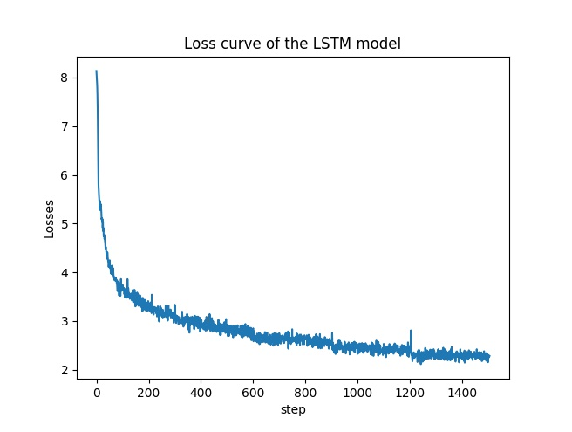

In [34]:
import matplotlib.pyplot as plt

x = list(range(len(losses)))
y = losses

plt.figure()
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('Losses')
plt.title("Loss curve of the RNN model")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'a', 'black', 'and', 'a', 'woman', 'in', 'front', 'of', 'a', 'building']
[['a', 'boy', 'wearing', 'a', 'mets', 'jersey', 'is', 'riding', 'a', 'bike', 'on', 'the', 'playground'], ['two', 'people', 'in', 'white', 'robes', 'look', 'at', 'a', 'snowy', 'mountain']]
1.268852357850863e-231


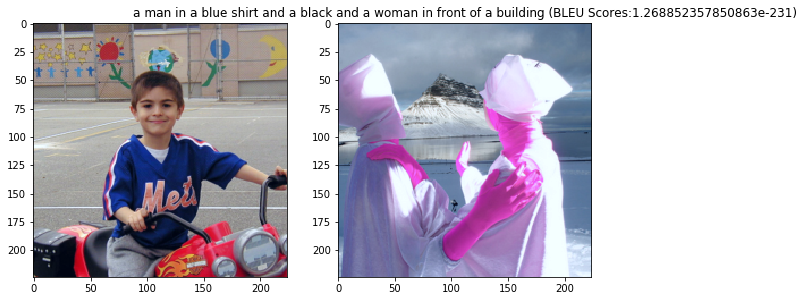

In [101]:
# LSTM models visualization and BLEU scores calculating
import matplotlib.pyplot as plt

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


lencoder.load_state_dict(torch.load('checkpoints/lstm-encoder-1-300.ckpt'))
ldecoder.load_state_dict(torch.load('checkpoints/lstm-decoder-1-300.ckpt'))

lencoder.eval()
ldecoder.eval()


sample_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=caption_collate_fn)
image,caption,length = next(iter(sample_loader))
image, caption = image.to(device), caption.to(device)

image = unorm(image)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image[0, :,:,:].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(image[1, :, :, :].permute(1,2,0).cpu().numpy())

feats = encoder(image)
sample_ids = ldecoder.sample(feats)
hypothese = sample_ids[0].cpu().tolist()
hypothese = [vocab.idx2word[hypo] for hypo in hypothese if hypo not in list(range(0,4))]
print(hypothese)

reference = caption.cpu().tolist()
refs = []
for i in range(2):
    ref = [vocab.idx2word[i] for i in reference[i] if i not in list(range(0,4))]
    refs.append(ref)
print(refs)

bleu = sentence_bleu(refs, hypothese)
print(bleu)
plt.title("{} (BLEU Scores:{})".format(" ".join(hypothese), bleu))
# plt.savefig("tmp_epoch_{}_sample.png".format(epoch))
plt.show()
plt.close()

### Comparsion between two models over the Test Set.

In [ ]:
# Build the RNN models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers, rnn_lstm = 'RNN').to(device)

encoder.eval()
decoder.eval()
encoder.load_state_dict(torch.load('checkpoints/rnn-encoder-5-300.ckpt'))
decoder.load_state_dict(torch.load('checkpoints/rnn-decoder-5-300.ckpt'))

# Build the LSTM models
lencoder = EncoderCNN(embed_size).to(device)
ldecoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers, rnn_lstm = 'LSTM').to(device)

lencoder.eval()
ldecoder.eval()
lencoder.load_state_dict(torch.load('checkpoints/lstm-encoder-5-300.ckpt'))
ldecoder.load_state_dict(torch.load('checkpoints/lstm-decoder-5-300.ckpt'))

for i, (images, captions, lengths) in enumerate(test_loader):
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        rnn_sample_ids = decoder.sample(features)
        rnn_hypothese = rnn_sample_ids[0].cpu().tolist()
        rnn_hypothese = [vocab.idx2word[hypo] for hypo in rnn_hypothese if hypo not in list(range(0,4))]
        print(rnn_hypothese)
        
        feats = lencoder(images)
        lstm_sample_ids = ldecoder.sample(feats)
        lstm_hypothese = lstm_sample_ids[0].cpu().tolist()
        lstm_hypothese = [vocab.idx2word[hypo] for hypo in lstm_hypothese if hypo not in list(range(0,4))]
        print(lstm_hypothese)

['a', 'young', 'boy', 'in', 'the', 'water', 'with', 'a', 'child', 'in', 'the', 'background', 'is', 'wearing', 'a', 'white', 'and', 'black']
['a', 'young', 'girl', 'in', 'a', 'pool', 'from', 'the', 'water']
['a', 'girl', 'in', 'a', 'swimming', 'pool', 'is', 'holding', 'a', 'yellow', 'ball', 'is', 'wearing', 'a', 'red']
['a', 'girl', 'in', 'a', 'pool', 'into', 'the', 'water', 'fountain', 'from', 'the', 'water']
['a', 'girl', 'in', 'a', 'blue', 'shirt', 'is', 'holding', 'a', 'spoon', 'in', 'the', 'ground', 'is', 'wearing']
['a', 'young', 'girl', 'in', 'a', 'blue', 'shirt', 'on', 'a', 'swing', 'from', 'a', 'rope']
['two', 'children', 'are', 'playing', 'in', 'a', 'game', 'is', 'wearing', 'a', 'red']
['a', 'young', 'girl', 'in', 'a', 'blue', 'shirt', 'on', 'a']
['a', 'girl', 'in', 'a', 'pool', 'is', 'holding', 'a', 'red', 'shirt', 'is', 'holding', 'a', 'yellow', 'and', 'a', 'wave']
['a', 'woman', 'in', 'a', 'brown', 'dog', 'is', 'standing', 'on', 'a', 'rock', 'face']
['three', 'children', 'p